In [81]:
pip install torch

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import torch
from nltk.sentiment import SentimentIntensityAnalyzer
from transformers import BertTokenizer, BertForSequenceClassification, RobertaTokenizer, RobertaForSequenceClassification, DistilBertTokenizer, DistilBertForSequenceClassification
from transformers import Trainer, TrainingArguments
from torch.utils.data import DataLoader, Dataset, TensorDataset
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from wordcloud import WordCloud
from collections import Counter

In [83]:
# Constant variable of file_path to read csv file
FILE_PATH = '/home/Reviews.csv'

# Defining a function to read a file which will return the dataframe
def read_dataset(file_path):
  return pd.read_csv(file_path)

# Calling a function to read a dataset and storing it to a variable
reviews_df = read_dataset(FILE_PATH)

**About the dataset**

568,454 food reviews Amazon users left up to October 2012

* Id: This is a unique identifier for each review entry in the dataset, ensuring that each review can be referenced uniquely.

* ProductId: This ID links the review to a specific product. This allows for aggregation of reviews by product.

* UserId: This identifies the user who wrote the review, allowing analysis of review patterns by user.

* ProfileName: This provides a human-readable name for the user who wrote the review.

* HelpfulnessNumerator: This indicates how many users found the review helpful, providing a measure of the review's perceived value.

* HelpfulnessDenominator: This is the total number of users who assessed the helpfulness of the review.

* Score: This is the rating given by the user, which is commonly used as the target variable for sentiment analysis.

* Time: This is the timestamp of when the review was posted, which can be used to analyze trends over time.

* Summary: This is a brief summary provided by the user, which can give a quick overview of the review's content.

* Text: This is the full text of the review, which contains the detailed opinion of the user and is typically the main input for sentiment analysis models.

**Purpose of this analysis**

The main objective of this sentiment analysis project is to gather understanding about the customer reviews and their natural tendencies on their corresponding platforms; and, to measure the performance of various approaches to sentiment analysis.

# **Basic Data Exploration**

In [84]:
# checking first 5 rows of the dataset
reviews_df.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bo

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [85]:
# Checking number of rows and columns of the dataset
reviews_df.shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(568454, 10)

We have 568454 records and 10 columns in our dataset

In [86]:
# As the dataset is massive, we reduced the size to 500
updated_reviews_df = reviews_df.head(500)
updated_reviews_df.shape # checking the updated dataframe rows and columns

(500, 10)

updated_reviews_df is a sample of our dataset with the top 100 records

# **Lets Handle the Missing Values**

In [87]:
updated_reviews_df.isnull().sum()

,0
Id,0
ProductId,0
UserId,0
ProfileName,0
HelpfulnessNumerator,0
HelpfulnessDenominator,0
Score,0
Time,0
Summary,0
Text,0



*   There are no null value in the dataset so we do not need to handle missing values

# **Text Preprocessing**


 We need the clean our review text by removing html tags, currency symbols, special characters and digits, converts text to lowercase, and removes extra whitespace. So we create the class TextPreprocessor which cleans our reviews data

In [88]:
import re # library for regular expression support
from bs4 import BeautifulSoup # library to parse and remove any HTML tags from the text.

# Defining a class to preprocess the `Text` and `Summary` column
class TextPreprocessor:
    def __init__(self, df):
        self.df = df
        print(f"Initial DataFrame shape: {self.df.shape}")

    def clean_text(self, text):
        if not isinstance(text, str):
            return ""
            # This checks if the input 'text' is a string or not. If it isnt it returns an empty string

        # Remove HTML tags using BeautifulSoup
        remove_html_text = BeautifulSoup(text, "html.parser").get_text()

        # Remove currency symbols
        remove_currency_text = re.sub(r'[\$€£¥₹]', '', remove_html_text)

        # Remove special characters and digits
        removed_special_character_text = re.sub(r"[^a-zA-Z\s]", "", remove_currency_text)

        # Convert text to lowercase
        lower_case_text = removed_special_character_text.lower()

        # Remove extra whitespaces
        final_text = re.sub(r"\s+", " ", lower_case_text).strip()

        return final_text

    def preprocess_text_column(self):
        # Apply the clean_text function to the 'Text' column
        self.df['Cleaned_Text'] = self.df['Text'].apply(self.clean_text)
        return self.df

    # Defining a function to preprocess the summary column
    def preprocess_summary_column(self, df):
        self.df = df
        # Apply the clean_text function to the 'Summary' column
        self.df['Cleaned_Summary'] = self.df['Summary'].apply(self.clean_text)
        return self.df

In [89]:
# Creating an instance of TextPreprocessor
preprocessor = TextPreprocessor(updated_reviews_df)

# Preprocess the `Text` column
cleaned_reviews_df = preprocessor.preprocess_text_column()

# Preprocess the `Summary` column
cleaned_reviews_df = preprocessor.preprocess_summary_column(cleaned_reviews_df)

Initial DataFrame shape: (500, 10)


<ipython-input-88-d129619d42b6>:16: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  remove_html_text = BeautifulSoup(text, "html.parser").get_text()
<ipython-input-88-d129619d42b6>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df['Cleaned_Text'] = self.df['Text'].apply(self.clean_text)
<ipython-input-88-d129619d42b6>:16: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  remove_html_text = BeautifulSoup(text, "html.parser").get_text()
<ipython-input-88-d129619d42b6>:41: SettingWithCopyWarning: 
A value is trying to be set 

In [90]:
cleaned_reviews_df.shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(500, 12)

In [91]:
cleaned_reviews_df.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Cleaned_Text,Cleaned_Summary
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,i have bought several of the vitality canned d...,good quality dog food
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,product arrived labeled as jumbo salted peanut...,not as advertised


We can see there are two new features - Cleaned_text and Cleaned_summary

# **Exploratory Data Analysis (EDA)**

### **1.   Distribution of Ratings**

In [92]:
# value counts of Score column
cleaned_reviews_df['Score'].value_counts()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,count
Score,
5,339
4,70
3,37
1,36
2,18


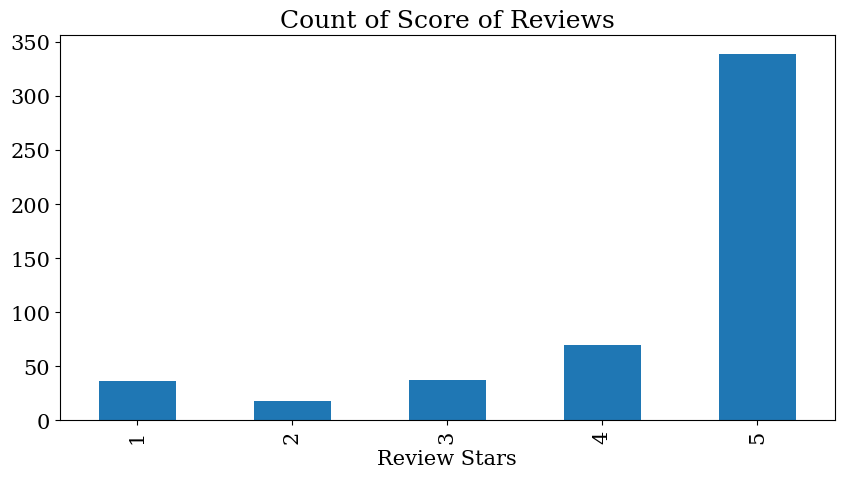

In [93]:
# ploting a bar chart of score column value_counts
ax = cleaned_reviews_df['Score'].value_counts().sort_index()\
    .plot(kind = 'bar',
    title = 'Count of Score of Reviews',
    figsize = (10, 5)) # figure size of the chart

ax.set_xlabel('Review Stars') # setting a label x axes
plt.show() # ploting the bar graph

We can observe majority of ratings in our dataset are for 5 star reviews

### **2. Review Length Analysis**

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


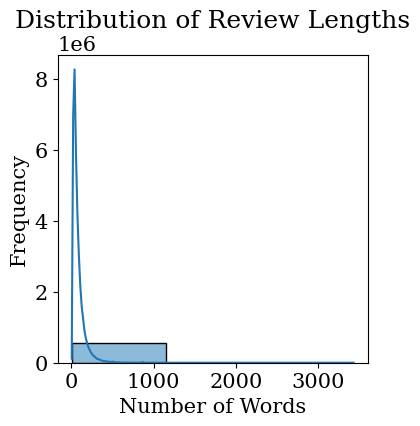

In [94]:
# Defining a function to calculate the length of reviews
def calculate_review_length(df, column):

    # Using lamda function to split the string by space and then calculating the length of the string
    df['Review_Length'] = df[column].apply(lambda x: len(str(x).split()))
    return df

# Calculate the length of reviews in the 'Text' column
calculated_reviews_length_df = calculate_review_length(reviews_df, 'Text')

# Plot the distribution of review lengths
plt.figure(figsize=(4, 4)) # Defining a figure size of the plot
sns.histplot(calculated_reviews_length_df['Review_Length'], bins=3, kde=True) # Using seaborn's histogram to review the plot
plt.title('Distribution of Review Lengths') # Setting a title for the histogram
plt.xlabel('Number of Words') # Defining x axes label
plt.ylabel('Frequency') # Defining y axes label
plt.show() # Displaying the histogram

In [95]:
calculated_reviews_length_df.Review_Length.max()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


3432

In [96]:
calculated_reviews_length_df.Review_Length.min()

3

Our reviews range from size 3 to 3432 characters


**Key Observations:**
* High Frequency of Short Reviews:

Short reviews containing 0-100 word count are characteristic of the language in most instances, and their prevalence is considerable. This is quite characteristic of review data sets as users tend to provide short descriptions.

* Long Tail Distribution:

Some of these reviews have very large numbers of words (up to 3432 words); however, such cases are in the minority.

* Skewness:

The reviews are again dominated by small sizes, thus showing a positively skewed distribution indicating that most are short with only a few very long.

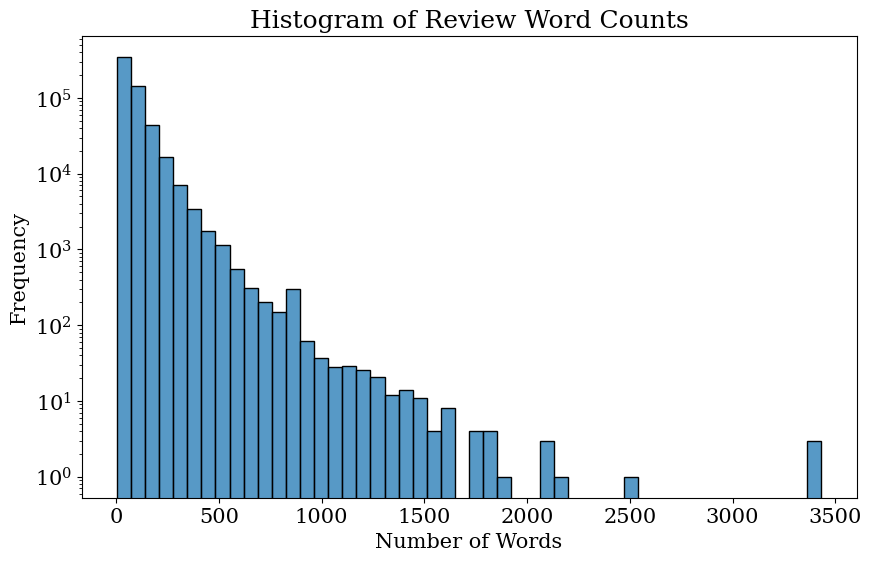

In [97]:
plt.figure(figsize=(10, 6))  # Increase the figure size for better visibility
sns.histplot(calculated_reviews_length_df['Review_Length'], bins=50, kde=False)  # Adjust bins as needed
plt.title('Histogram of Review Word Counts')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.yscale('log')  # Optional: Use a logarithmic scale for better visualization of long tails
plt.show()

As we can see most reviews are short. Most reviews have less than 1000 word. There are very few with around 3500. The highest being 3432

# **Model Selection and Training**

In [98]:
cleaned_reviews_df.shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(500, 12)

In [99]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets.
def split_train_test(data, target, test_size=0.2, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=test_size, random_state=random_state)
    return X_train, X_test, y_train, y_test

In [100]:
# Splitting the cleaned reviews dataset into training and test sets
X_train, X_test, y_train, y_test = split_train_test(cleaned_reviews_df['Cleaned_Text'], cleaned_reviews_df['Score'])

# Further split the training set into training and validation sets (20% for validation)
X_train, X_val, y_train, y_val = split_train_test(X_train, y_train, test_size=0.2, random_state=42)

# Create a DataFrame for the training set
df_train = pd.DataFrame({'Cleaned_Text': X_train, 'Score': y_train})

# Create a DataFrame for the validation set
df_val = pd.DataFrame({'Cleaned_Text': X_val, 'Score': y_val})

# Create a DataFrame for the test set
df_test = pd.DataFrame({'Cleaned_Text': X_test, 'Score': y_test})

### **i. VADER model**
Valence Aware Dictionary and sEntiment Reasoner (VADER)

VADER uses a lexicon of sentiment-related words to determine the overall sentiment of a given body of text.

In [101]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [102]:
# Import the VADER sentiment analyzer from the NLTK library
from nltk.sentiment import SentimentIntensityAnalyzer
import numpy as np

# Initialize the VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Function to classify sentiment based on VADER's compound score
def vader_sentiment(text):
    """
    Classify sentiment using VADER based on the compound score.
    """
    # Get the sentiment scores for the input text
    sentiment_dict = sia.polarity_scores(text)

    # Extract the compound score
    compound_score = sentiment_dict['compound']

    # Determine sentiment based on the compound score
    if compound_score >= 0.05:
        return 'positive'  # Positive sentiment if compound score is >= 0.05
    elif compound_score <= -0.05:
        return 'negative'  # Negative sentiment if compound score is <= -0.05
    else:
        return 'neutral'   # Neutral sentiment otherwise

# Function to create sentiment labels based on the Score column
def score_to_sentiment(score):
    """
    Convert numerical scores to sentiment labels.
    """
    if score >= 4:
        return 'positive'  # Positive sentiment for scores 4 and 5
    elif score == 3:
        return 'neutral'   # Neutral sentiment for score 3
    else:
        return 'negative'  # Negative sentiment for scores 1 and 2

# Apply the sentiment functions to each DataFrame
for df in [df_train, df_val, df_test]:
    # Apply VADER sentiment analysis to the 'Cleaned_Text' column
    df['VADER_Sentiment'] = df['Cleaned_Text'].apply(vader_sentiment)

    # Convert numerical scores to sentiment labels in the 'Score' column
    df['Score_Sentiment'] = df['Score'].apply(score_to_sentiment)

    # Determine whether VADER's sentiment prediction matches the score-based sentiment
    df['Sentiment_Match'] = np.where(df['VADER_Sentiment'] == df['Score_Sentiment'], 'Match', 'Mismatch')

# Calculate the match percentage for each DataFrame
# Match percentage indicates how often VADER's predictions match the actual sentiment based on scores

# Training set match percentage
match_percentage_train = df_train['Sentiment_Match'].value_counts(normalize=True) * 100

# Validation set match percentage
match_percentage_val = df_val['Sentiment_Match'].value_counts(normalize=True) * 100

# Test set match percentage
match_percentage_test = df_test['Sentiment_Match'].value_counts(normalize=True) * 100

# Display the match percentages for each dataset
print("Training Set Match Percentage:\n", match_percentage_train)
print("\nValidation Set Match Percentage:\n", match_percentage_val)
print("\nTest Set Match Percentage:\n", match_percentage_test)

# Display the first few rows of each DataFrame to inspect the results
print("\nTraining Set:\n", df_train.head())
print("\nValidation Set:\n", df_val.head())
print("\nTest Set:\n", df_test.head())


Training Set Match Percentage:
 Sentiment_Match
Match       82.1875
Mismatch    17.8125
Name: proportion, dtype: float64

Validation Set Match Percentage:
 Sentiment_Match
Match       86.25
Mismatch    13.75
Name: proportion, dtype: float64

Test Set Match Percentage:
 Sentiment_Match
Match       81.0
Mismatch    19.0
Name: proportion, dtype: float64

Training Set:
                                           Cleaned_Text  Score VADER_Sentiment  \
322  i was amazed at how quickly it arrived it is a...      3        positive   
117  in the s i spent several summers in italy this...      5        positive   
311  the package came with the label torn off and n...      1        negative   
254  i felt energized within five minutes but it la...      1        positive   
288  i have to get up really early to work out befo...      5        positive   

    Score_Sentiment Sentiment_Match  
322         neutral        Mismatch  
117        positive           Match  
311        negative           

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


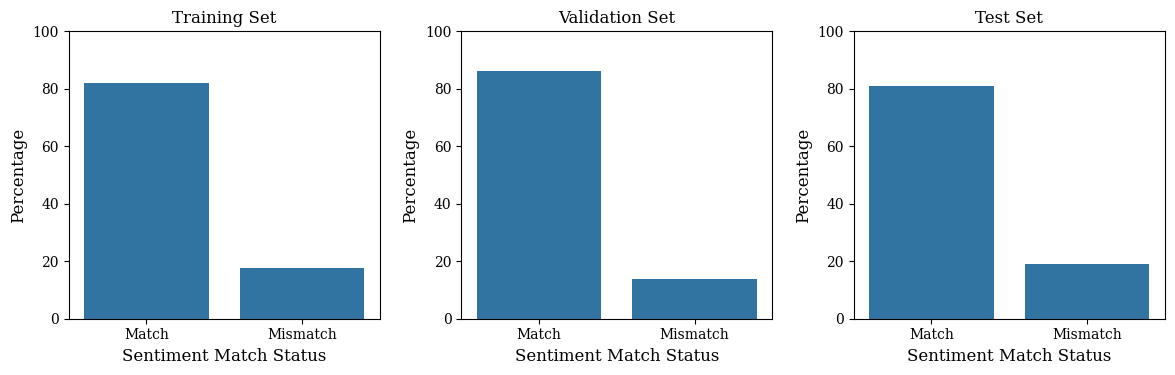

In [103]:
# Function to plot match percentages in a single row of subplots
def plot_match_percentages_row(match_percentages, titles):
    # Create a figure with a row of 3 subplots
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    # Loop through each dataset's match percentage and its corresponding title
    for i, (match_percentage, title) in enumerate(zip(match_percentages, titles)):
        # Create a bar plot for the current match percentage
        sns.barplot(x=match_percentage.index, y=match_percentage.values, ax=axes[i])
        axes[i].set_title(title, fontsize=12)
        axes[i].set_ylabel('Percentage', fontsize=12)
        axes[i].set_xlabel('Sentiment Match Status', fontsize=12)
        # Set the y-axis limits to ensure consistency across all plots
        axes[i].set_ylim(0, 100)
        # Adjust the font size of the tick labels for readability
        axes[i].tick_params(axis='x', labelsize=10)
        axes[i].tick_params(axis='y', labelsize=10)

    # Adjust the layout to prevent overlap between plots
    plt.tight_layout()
    plt.show()

# List of match percentages for training, validation, and test datasets
match_percentages = [match_percentage_train, match_percentage_val, match_percentage_test]

# Corresponding titles for each subplot
titles = ['Training Set', 'Validation Set', 'Test Set']

# Plot match percentages for each dataset in a single row
plot_match_percentages_row(match_percentages, titles)

In [104]:
# Function to calculate and print accuracy
def calculate_accuracy(y_true, y_pred, title):
    accuracy = accuracy_score(y_true, y_pred)
    print(f'{title} Accuracy: {accuracy * 100:.2f}%')

# Function to print classification report
def print_classification_report(y_true, y_pred, title):
    report = classification_report(y_true, y_pred, labels=['positive', 'neutral', 'negative'])
    print(f'\n{title} Classification Report:\n{report}')

# Apply these functions to each dataset
for df, title in zip([df_train, df_val, df_test], ["Training Set", "Validation Set", "Test Set"]):

    # Calculate and print accuracy
    calculate_accuracy(df['Score_Sentiment'], df['VADER_Sentiment'], title)

    # Print classification report
    print_classification_report(df['Score_Sentiment'], df['VADER_Sentiment'], title)

Training Set Accuracy: 82.19%

Training Set Classification Report:
              precision    recall  f1-score   support

    positive       0.89      0.93      0.91       261
     neutral       0.22      0.08      0.12        24
    negative       0.50      0.54      0.52        35

    accuracy                           0.82       320
   macro avg       0.54      0.52      0.52       320
weighted avg       0.79      0.82      0.81       320

Validation Set Accuracy: 86.25%

Validation Set Classification Report:
              precision    recall  f1-score   support

    positive       0.89      0.99      0.94        67
     neutral       0.00      0.00      0.00         4
    negative       0.75      0.33      0.46         9

    accuracy                           0.86        80
   macro avg       0.55      0.44      0.47        80
weighted avg       0.83      0.86      0.84        80

Test Set Accuracy: 81.00%

Test Set Classification Report:
              precision    recall  f1-sco

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


There are few scores that are few text whihc contains both positive and negative sentiment so let's check that with Aspect Based Sentiment Analysis

### **ii. Aspect Based Sentiment Analysis**

In [105]:
pip install -U pyabsa

In [106]:
from pyabsa import ATEPCCheckpointManager

# Initialize the aspect extractor with the desired checkpoint
aspect_extractor = ATEPCCheckpointManager.get_aspect_extractor(
    checkpoint='english',  # Use the 'english' checkpoint
    auto_device=True       # Use GPU if available, otherwise fallback to CPU
)

[2024-08-15 08:03:48] (2.4.1.post1) ********** Available ATEPC model checkpoints for Version:2.4.1.post1 (this version) **********
[2024-08-15 08:03:48] (2.4.1.post1) ********** Available ATEPC model checkpoints for Version:2.4.1.post1 (this version) **********
[2024-08-15 08:03:48] (2.4.1.post1) Downloading checkpoint:english 
[2024-08-15 08:03:48] (2.4.1.post1) Notice: The pretrained model are used for testing, it is recommended to train the model on your own custom datasets
[2024-08-15 08:03:48] (2.4.1.post1) Checkpoint already downloaded, skip
[2024-08-15 08:03:48] (2.4.1.post1) Load aspect extractor from checkpoints/ATEPC_ENGLISH_CHECKPOINT/fast_lcf_atepc_English_cdw_apcacc_82.36_apcf1_81.89_atef1_75.43
[2024-08-15 08:03:48] (2.4.1.post1) config: checkpoints/ATEPC_ENGLISH_CHECKPOINT/fast_lcf_atepc_English_cdw_apcacc_82.36_apcf1_81.89_atef1_75.43/fast_lcf_atepc.config
[2024-08-15 08:03:48] (2.4.1.post1) state_dict: checkpoints/ATEPC_ENGLISH_CHECKPOINT/fast_lcf_atepc_English_cdw_apc

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:562: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [ ]:
# Function to perform ABSA on a DataFrame
def apply_absa(df, aspect_extractor):
    # Assuming 'Cleaned_Text' is the column containing the reviews
    absa_results = df['Cleaned_Text'].apply(lambda x: aspect_extractor.extract_aspect(inference_source=[x], pred_sentiment=True))

    # Extract aspect terms and sentiments from results
    aspects_sentiments = []
    for result in absa_results:
        # Since result is a list, we'll iterate through each entry (typically only one per inference call)
        for res in result:
            aspects = list(zip(res['aspect'], res['sentiment']))  # Combine aspect terms with their sentiment
            aspects_sentiments.append(aspects)

    df['Aspects_Sentiments'] = aspects_sentiments
    return df

# Apply ABSA on df_train, df_val, and df_test
df_train = apply_absa(df_train, aspect_extractor)
df_val = apply_absa(df_val, aspect_extractor)
df_test = apply_absa(df_test, aspect_extractor)

# Display the results
print(df_train[['Cleaned_Text', 'Aspects_Sentiments']].head())
print(df_val[['Cleaned_Text', 'Aspects_Sentiments']].head())
print(df_test[['Cleaned_Text', 'Aspects_Sentiments']].head())

<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


[2024-08-15 08:04:11] (2.4.1.post1) The results of aspect term extraction have been saved in /content/Aspect Term Extraction and Polarity Classification.FAST_LCF_ATEPC.result.json
[2024-08-15 08:04:11] (2.4.1.post1) Example 0: i was amazed at how quickly it arrived it is a cute <stocking stuffer:Positive Confidence:0.9811> but only ok as far as user appeal you get what you pay for
[2024-08-15 08:04:24] (2.4.1.post1) The results of aspect term extraction have been saved in /content/Aspect Term Extraction and Polarity Classification.FAST_LCF_ATEPC.result.json
[2024-08-15 08:04:24] (2.4.1.post1) Example 0: in the s i spent several summers in italy this <biscotti:Positive Confidence:0.9981> is often given as a breakfast <food:Positive Confidence:0.9406> or midday snack they are simple and delicious and were not sold in the us back then they are so good that i brought back two bags from a recent trip to italy it is great to see that they may now be found on amazonnote it is great to open a 

In [ ]:
# Function to generate and plot a word cloud for aspects
def plot_aspect_wordcloud(df, title):
    # Flatten the list of aspects
    aspects = [aspect for aspects_sentiments in df['Aspects_Sentiments'] for aspect, sentiment in aspects_sentiments]

    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(aspects))

    # Plot word cloud
    plt.figure(figsize=(6, 4))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Aspect Word Cloud: {title}', fontsize=14)
    plt.axis('off')
    plt.show()


# Apply these visualizations to each dataset
for df, title in zip([df_train, df_val, df_test], ["Training Set", "Validation Set", "Test Set"]):
    plot_aspect_wordcloud(df, title)

### **iii. BERT Models**

In [ ]:
class BertSentimentAnalyzer:
    def __init__(self):
        """
        Initialize the BertSentimentAnalyzer class by loading pre-trained models and tokenizers.
        The models and tokenizers are loaded for BERT, RoBERTa, and DistilBERT.
        """
        # Load BERT model and tokenizer
        self.bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)
        self.bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

        # Load RoBERTa model and tokenizer
        self.roberta_model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=3)
        self.roberta_tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

        # Load DistilBERT model and tokenizer
        self.distilbert_model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=3)
        self.distilbert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

    def bert_sentiment(self, text):
        """
        Classify sentiment using the BERT model.
        """
        # Tokenize the input text using the BERT tokenizer
        inputs = self.bert_tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)

        # Pass the tokenized input through the BERT model to get outputs
        outputs = self.bert_model(**inputs)

        # Apply softmax to get probabilities of each sentiment class
        probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)

        # Get the class with the highest probability (the predicted sentiment)
        _, prediction = torch.max(probabilities, dim=1)

        # Convert the numeric prediction to a sentiment label
        return self._get_sentiment_label(prediction)

    def roberta_sentiment(self, text):
        """
        Classify sentiment using the RoBERTa model.
        """
        # Tokenize the input text using the RoBERTa tokenizer
        inputs = self.roberta_tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)

        # Pass the tokenized input through the RoBERTa model to get outputs
        outputs = self.roberta_model(**inputs)

        # Apply softmax to get probabilities of each sentiment class
        probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)

        # Get the class with the highest probability (the predicted sentiment)
        _, prediction = torch.max(probabilities, dim=1)

        # Convert the numeric prediction to a sentiment label
        return self._get_sentiment_label(prediction)

    def distilbert_sentiment(self, text):
        """
        Classify sentiment using the DistilBERT model.
        """
        # Tokenize the input text using the DistilBERT tokenizer
        inputs = self.distilbert_tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)

        # Pass the tokenized input through the DistilBERT model to get outputs
        outputs = self.distilbert_model(**inputs)

        # Apply softmax to get probabilities of each sentiment class
        probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)

        # Get the class with the highest probability (the predicted sentiment)
        _, prediction = torch.max(probabilities, dim=1)

        # Convert the numeric prediction to a sentiment label
        return self._get_sentiment_label(prediction)

    def apply_sentiment_analysis(self, df):
        """
        Apply sentiment analysis to a DataFrame using BERT, RoBERTa, and DistilBERT models.
        """
        # Apply BERT sentiment analysis to the 'Cleaned_Text' column and store the results
        df['BERT_Sentiment'] = df['Cleaned_Text'].apply(self.bert_sentiment)

        # Apply RoBERTa sentiment analysis to the 'Cleaned_Text' column and store the results
        df['RoBERTa_Sentiment'] = df['Cleaned_Text'].apply(self.roberta_sentiment)

        # Apply DistilBERT sentiment analysis to the 'Cleaned_Text' column and store the results
        df['DistilBERT_Sentiment'] = df['Cleaned_Text'].apply(self.distilbert_sentiment)

        # Compare BERT predictions with actual labels and store the match/mismatch status
        df['Sentiment_Match_BERT'] = np.where(df['BERT_Sentiment'] == df['Score_Sentiment'], 'Match', 'Mismatch')

        # Compare RoBERTa predictions with actual labels and store the match/mismatch status
        df['Sentiment_Match_RoBERTa'] = np.where(df['RoBERTa_Sentiment'] == df['Score_Sentiment'], 'Match', 'Mismatch')

        # Compare DistilBERT predictions with actual labels and store the match/mismatch status
        df['Sentiment_Match_DistilBERT'] = np.where(df['DistilBERT_Sentiment'] == df['Score_Sentiment'], 'Match', 'Mismatch')

    def calculate_match_percentages(self, df_train, df_val, df_test):
        """
        Calculate and print match percentages for training, validation, and test datasets.
        """
        # Loop through each model (BERT, RoBERTa, DistilBERT)
        for model_name in ['BERT', 'RoBERTa', 'DistilBERT']:
            match_percentage_train = df_train[f'Sentiment_Match_{model_name}'].value_counts(normalize=True) * 100  # Calculate match percentage for the training set
            match_percentage_val = df_val[f'Sentiment_Match_{model_name}'].value_counts(normalize=True) * 100  # Calculate match percentage for the validation set
            match_percentage_test = df_test[f'Sentiment_Match_{model_name}'].value_counts(normalize=True) * 100  # Calculate match percentage for the test set

            print(f"\nTraining Set Match Percentage for {model_name}:\n", match_percentage_train) # Print match percentages for the training set
            print(f"\nValidation Set Match Percentage for {model_name}:\n", match_percentage_val) # Print match percentages for the validation set
            print(f"\nTest Set Match Percentage for {model_name}:\n", match_percentage_test)  # Print match percentages for the test set

    def _get_sentiment_label(self, prediction):
        """
        Helper function to map model prediction to sentiment label.
        """
        # Map the numeric prediction to the appropriate sentiment label
        if prediction == 2:
            return 'positive'
        elif prediction == 1:
            return 'neutral'
        else:
            return 'negative'


In [ ]:
# Instantiate the BertSentimentAnalyzer class to create an analyzer object
bertSentimentAnalyzer = BertSentimentAnalyzer()

# Apply sentiment analysis to the training dataset
# This will add columns for BERT, RoBERTa, and DistilBERT predicted sentiments,
# as well as columns indicating whether each prediction matches the actual sentiment.
bertSentimentAnalyzer.apply_sentiment_analysis(df_train)

# Apply sentiment analysis to the validation dataset
# Similar to the training dataset, this will process the validation dataset to include
# predictions and match/mismatch information.
bertSentimentAnalyzer.apply_sentiment_analysis(df_val)

# Apply sentiment analysis to the test dataset
# This processes the test dataset to include predictions and match/mismatch information.
bertSentimentAnalyzer.apply_sentiment_analysis(df_test)

# Calculate and print match percentages for each dataset
# This method will compute the percentage of matches between the predicted and actual sentiments
# for BERT, RoBERTa, and DistilBERT on the training, validation, and test datasets.
bertSentimentAnalyzer.calculate_match_percentages(df_train, df_val, df_test)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

# Function to print accuracy and classification report
def print_classification_metrics(y_true, y_pred, model_name, dataset_name):
    """
    Prints the accuracy and classification report for a specific model on a given dataset.

    Parameters:
    y_true (pd.Series): The actual sentiment labels.
    y_pred (pd.Series): The predicted sentiment labels by the model.
    model_name (str): The name of the model (e.g., BERT, RoBERTa).
    dataset_name (str): The name of the dataset (e.g., Training Set).
    """
    # Calculate the accuracy score
    accuracy = accuracy_score(y_true, y_pred)

    print(f'{dataset_name} Accuracy for {model_name}: {accuracy * 100:.2f}%')     # Print the accuracy as a percentage

    print(f'{dataset_name} Classification Report for {model_name}:\n')     # Print the classification report name
    print(classification_report(y_true, y_pred, labels=['positive', 'neutral', 'negative']))  # Print the classification report
    print("\n" + "="*60 + "\n")

# Iterate over each model and dataset to create the visualizations and metrics
for model_name in ['BERT', 'RoBERTa', 'DistilBERT']:
    """
    Loop through each model (BERT, RoBERTa, DistilBERT) and each dataset
    (Training, Validation, Test) to calculate and print accuracy and classification metrics.
    """
    for df, dataset_name in zip([df_train, df_val, df_test], ["Training Set", "Validation Set", "Test Set"]):
        # Get the true sentiment labels from the dataset
        y_true = df['Score_Sentiment']

        # Get the predicted sentiment labels from the model-specific column
        y_pred = df[f'{model_name}_Sentiment']
        print_classification_metrics(y_true, y_pred, model_name, dataset_name)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Function to plot match percentage in a subplot
def plot_mismatch_percentage_subplot(ax, match_percentage, model_name, dataset_name):
    """
    Plots the mismatch percentage for a specific model in a given subplot.

    Parameters:
    ax (matplotlib.axes.Axes): The subplot axis to plot on.
    match_percentage (pd.Series): The percentage of matches and mismatches.
    model_name (str): The name of the model (e.g., VADER, BERT).
    dataset_name (str): The name of the dataset (e.g., Training Set).
    """
    sns.barplot(x=match_percentage.index, y=match_percentage.values, palette='Blues', ax=ax)
    ax.set_title(f'{model_name}', fontsize=14)  # Set the title with the model name
    ax.set_ylabel('Percentage', fontsize=10)    # Set the y-axis label
    ax.set_xlabel('Match Status', fontsize=10)  # Set the x-axis label
    ax.set_ylim(0, 100)                         # Set y-axis limits from 0 to 100
    ax.tick_params(axis='x', labelsize=8)       # Set x-axis tick label size
    ax.tick_params(axis='y', labelsize=8)       # Set y-axis tick label size

# Function to plot confusion matrix in a subplot
def plot_confusion_matrix_subplot(ax, y_true, y_pred, model_name):
    """
    Plots the confusion matrix for a specific model in a given subplot.

    Parameters:
    ax (matplotlib.axes.Axes): The subplot axis to plot on.
    y_true (pd.Series): The actual sentiment labels.
    y_pred (pd.Series): The predicted sentiment labels by the model.
    model_name (str): The name of the model (e.g., VADER, BERT).
    """
    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=['positive', 'neutral', 'negative'])
    # Plot the confusion matrix as a heatmap
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=['positive', 'neutral', 'negative'],
                yticklabels=['positive', 'neutral', 'negative'], ax=ax)
    ax.set_title(f'{model_name}', fontsize=14)  # Set the title with the model name
    ax.set_ylabel('Actual', fontsize=10)        # Set the y-axis label
    ax.set_xlabel('Predicted', fontsize=10)     # Set the x-axis label
    ax.tick_params(axis='x', labelsize=8)       # Set x-axis tick label size
    ax.tick_params(axis='y', labelsize=8)       # Set y-axis tick label size

# Function to plot all models' mismatch percentage and confusion matrices in a single row
def plot_all_models_mismatch_and_confusion(df, dataset_name):
    """
    Plots mismatch percentages and confusion matrices for VADER, BERT, RoBERTa, and DistilBERT
    in a single row for a given dataset.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the sentiment data.
    dataset_name (str): The name of the dataset (e.g., Training Set).
    """
    # Create subplots for mismatch percentages
    fig, axes = plt.subplots(1, 4, figsize=(20, 4))  # 1 row, 4 columns for 4 models
    model_names = ['VADER', 'BERT', 'RoBERTa', 'DistilBERT']  # List of model names

    for i, model_name in enumerate(model_names):
        # Determine the correct column names for match status and sentiment based on the model
        match_column = f'Sentiment_Match_{model_name}' if model_name != 'VADER' else 'Sentiment_Match'
        sentiment_column = f'{model_name}_Sentiment' if model_name != 'VADER' else 'VADER_Sentiment'

        # Calculate match percentage
        match_percentage = df[match_column].value_counts(normalize=True) * 100
        # Plot mismatch percentage for each model
        plot_mismatch_percentage_subplot(axes[i], match_percentage, model_name, dataset_name)

    plt.suptitle(f'Mismatch Percentage Comparison - {dataset_name}', fontsize=16)  # Super title for the entire row
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit titles and labels
    plt.show()

    # Create subplots for confusion matrices
    fig, axes = plt.subplots(1, 4, figsize=(20, 4))  # 1 row, 4 columns for 4 models

    for i, model_name in enumerate(model_names):
        # Determine the correct column name for sentiment based on the model
        sentiment_column = f'{model_name}_Sentiment' if model_name != 'VADER' else 'VADER_Sentiment'
        y_true = df['Score_Sentiment']  # Actual sentiment labels
        y_pred = df[sentiment_column]   # Predicted sentiment labels by the model

        # Plot confusion matrix for each model
        plot_confusion_matrix_subplot(axes[i], y_true, y_pred, model_name)

    plt.suptitle(f'Confusion Matrix Comparison - {dataset_name}', fontsize=16)  # Super title for the entire row
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit titles and labels
    plt.show()

# Apply the plotting functions to each dataset (Training, Validation, Test)
for df, dataset_name in zip([df_train, df_val, df_test], ["Training Set", "Validation Set", "Test Set"]):
    plot_all_models_mismatch_and_confusion(df, dataset_name)


# Conclusion

In this analysis, we explored the sentiment scores including 'neg', 'neu', and 'pos' for each text entry in our dataset.
We observed how these sentiment scores provide insights into the overall emotional tone of the texts, helping us identify predominant sentiments.

The use of sentiment analysis can be valuable in understanding customer feedback, social media interactions, or any other textual data where gauging the emotional tone is important.

Moving forward, these insights can be used to tailor responses, enhance user experience, or inform decision-making processes in various applications.